In [ ]:
# 0 - Normal
# 1 - Pneumonia
# 2 - Tuberculosis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_recall_curve

from scipy.optimize import brute
from skopt import forest_minimize, gbrt_minimize, dummy_minimize
from skopt import callbacks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [ ]:
# Code to enable the use of the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Ccode for print report and matrix side by side
CSS = """
.output {
    flex-direction: row;
}
"""

display(HTML('<style>{}</style>'.format(CSS)))

labels = [ "Normal", "Pneumonia", "Tuberculosis" ]

dataset = []
label = []

Size = 64

In [ ]:
#Read each image from the train and test data and assiging labels 

image_directory = r'C:\Users\rahulmaddula\Desktop\Sem 2\Data Driven Modeling\Assignments\Project\Final\Images'

Normal_images = os.listdir(image_directory + '/Normal/')
for i, image_name in enumerate(Normal_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpeg'):
        image = load_img(image_directory + '/Normal/' + image_name, color_mode = 'rgb')
        
        image = image.resize((Size,Size))
        dataset.append((img_to_array(image)))
        label.append(0)
        
Pneumonia_images = os.listdir(image_directory + '/Pneumonia/')
for i, image_name in enumerate(Pneumonia_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpeg'):
        image = load_img(image_directory + '/Pneumonia/' + image_name, color_mode ='rgb')
        
        image = image.resize((Size,Size))
        dataset.append((img_to_array(image)))
        label.append(1)

Tuberculosis_images = os.listdir(image_directory + '/Tuberculosis/')
for i, image_name in enumerate(Tuberculosis_images):    #Remember enumerate method adds a counter and returns the enumerate object

    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpeg'):
        image = load_img(image_directory + '/Tuberculosis/' + image_name, color_mode ='rgb')
        
        image = image.resize((Size,Size))
        dataset.append((img_to_array(image)))
        label.append(2)
        

In [ ]:
#Processing the data to as input for the neural network
x_data = np.array(dataset)


#One hot encode y values for neural network. 
y_labels = to_categorical(label)

# Split the data for train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_labels, test_size = 0.1, random_state = 60616)

In [ ]:
#Setting the feature extraction model
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape = (Size, Size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
Total params: 1,024
Trainable params: 960
Non-trainable params: 64
_________________________________________________________________
None


In [ ]:
#Add fully connected layers for deep learning prediction
x = model.output  
prediction_layer = Dense(3, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=model.input, outputs=prediction_layer)

sgd_optimizer = optimizers.SGD(momentum=0.8)
cnn_model.compile(optimizer=sgd_optimizer, loss = 'categorical_crossentropy', metrics = [Recall()])
print(cnn_model.summary()) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 98307     
Total params: 99,331
Trainable params: 99,267
Non-trainable params: 64
_________________________________________________

In [ ]:
# Train the CNN Model

my_callback = [EarlyStopping(monitor = 'val_recall', mode = 'max', patience = 3)]


history = cnn_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), shuffle = False, batch_size=64)

Epoch 1/20
165/165 [==============================] - 1s 8ms/step - loss: 1.1784 - recall: 0.8703 - val_loss: 0.4648 - val_recall: 0.8590
Epoch 2/20
165/165 [==============================] - 1s 6ms/step - loss: 0.2678 - recall: 0.9190 - val_loss: 0.7249 - val_recall: 0.8034
Epoch 3/20
165/165 [==============================] - 1s 6ms/step - loss: 0.1721 - recall: 0.9400 - val_loss: 0.1947 - val_recall: 0.9342
Epoch 4/20
165/165 [==============================] - 1s 6ms/step - loss: 0.1437 - recall: 0.9495 - val_loss: 0.2011 - val_recall: 0.9308
Epoch 5/20
165/165 [==============================] - 1s 6ms/step - loss: 0.1257 - recall: 0.9562 - val_loss: 0.1897 - val_recall: 0.9402
Epoch 6/20
165/165 [==============================] - 1s 6ms/step - loss: 0.1140 - recall: 0.9604 - val_loss: 0.1930 - val_recall: 0.9453
Epoch 7/20
165/165 [==============================] - 1s 6ms/step - loss: 0.1033 - recall: 0.9654 - val_loss: 0.1941 - val_recall: 0.9462
Epoch 8/20
165/165 [==============

In [ ]:
#Predict the label for test data
y_pred = cnn_model.predict(x_test)

# Converting the predicted values into a array of label
y_true_1 = np.array([np.argmax(y, axis=None, out=None) for y in y_test])
y_predict_1 = np.array([np.argmax(y, axis=None, out=None) for y in y_pred])

In [ ]:
# Assigning the labels integer with classes names
y_actual_1 = y_true_1.astype('object')
y_predicted_1 = y_predict_1.astype('object')


for i in range(len(labels)):
    y_actual_1[y_actual_1 == i] = labels[i]
    y_predicted_1[y_predicted_1 == i] = labels[i]


              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94       377
   Pneumonia       0.95      0.98      0.97       430
Tuberculosis       0.98      0.92      0.95       363

    accuracy                           0.95      1170
   macro avg       0.95      0.95      0.95      1170
weighted avg       0.95      0.95      0.95      1170



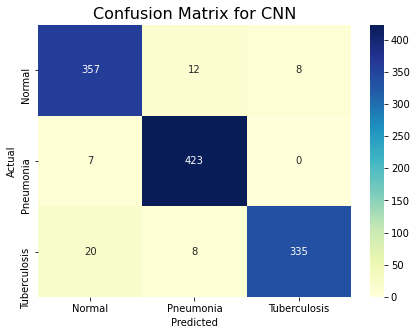

In [ ]:
# Print the classification report

print(classification_report(y_actual_1, y_predicted_1))

# Plot the Confusion Matrix 

y_actual_1 = pd.Series(y_actual_1, name='Actual')
y_predicted_1 = pd.Series(y_predicted_1, name='Predicted')
confusion_matrix = pd.crosstab(y_actual_1, y_predicted_1, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (7,5))
sns.heatmap(confusion_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix for CNN", fontsize=16)
plt.show()

# CNN + RandomForest

In [ ]:
# Input for the Radom Forest model for training

x_train_feature =  model.predict(x_train)

# Input for the Radom Forest model for prediction

x_test_feature = model.predict(x_test)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 70.8900
Function value obtained: -0.9487
Current minimum: -0.9487
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 66.0014
Function value obtained: -0.9410
Current minimum: -0.9487
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.0857
Function value obtained: -0.9162
Current minimum: -0.9487
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 20.6891
Function value obtained: -0.9368
Current minimum: -0.9487
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 144.0391
Function value obtained: -0.9436
Current minimum: -0.9487
Iteration No: 6 star

C:\Users\jainp\anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 8.8636
Function value obtained: -0.9479
Current minimum: -0.9650
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 80.9320
Function value obtained: -0.9410
Current minimum: -0.9650
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 64.8376
Function value obtained: -0.9598
Current minimum: -0.9650
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 39.0798
Function value obtained: -0.9504
Current minimum: -0.9650
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 37.9898
Function value obtained: -0.9504
Current minimum: -0.9650
Iteration No: 3

C:\Users\jainp\anaconda3\envs\tf\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 68.6101
Function value obtained: -0.9504
Current minimum: -0.9650
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 60.5184
Function value obtained: -0.9521
Current minimum: -0.9650
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 37.8060
Function value obtained: -0.9444
Current minimum: -0.9650
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 5.4785
Function value obtained: -0.9496
Current minimum: -0.9650
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 57.8312
Function value obtained: -0.9521
Current minimum: -0.9650
Iteration No: 5

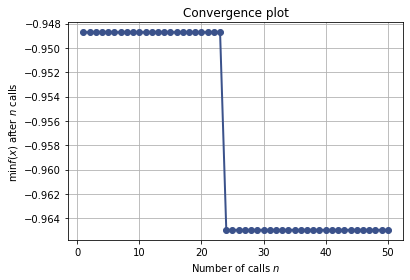

In [ ]:
# Hyperparameters tuning for Random Forest Parameters
# Bayesian Optimization

num_thread= 50
params = ['n_estimators', 'criterion', 'min_samples_split', 'min_samples_leaf', 'max_features','bootstrap']

#for model include item_Features
def objective(params):
    # unpack
    n_estimators, criterion, min_samples_split, min_samples_leaf, max_features, bootstrap = params
    
    model_iii = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap = bootstrap, random_state=60616)
    model_iii.fit(x_train_feature, y_train)
    
    prediction_test = model_iii.predict(x_test_feature)
    recall = recall_score(y_test, prediction_test, average='micro')

    out = -recall
    # Handle some numerical issue going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

space = [(20, 40, 50, 60, 80, 100,),
         ('gini', 'entropy'),
         (5, 10, 15, 20, 25, 30, 35),
         (2, 6, 10, 14, 18, 22, 26, 30),
         ('auto', 'sqrt', 'log2'),
         (True, False),
        ]

try:
    res_fm = forest_minimize(objective, space, n_calls=num_thread,
                     random_state=60616,base_estimator= 'RF',acq_func='PI',
                     verbose=True, n_jobs= -1)
except ValueError:
    print('Forest diverged, random search intialized')
    res_fm = dummy_minimize(objective, space, n_calls=num_thread,
         random_state=60616,
         verbose=True)

print('Maximimum Recall_score found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')

for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))
from skopt.plots import plot_convergence
plot_convergence(res_fm);

In [ ]:
# Train the Random Forest Model
RF_model = RandomForestClassifier(n_estimators = 80, criterion = 'gini', min_samples_split = 10, min_samples_leaf = 2, max_features= 'sqrt', bootstrap = False, random_state = 60616)

RF_model.fit(x_train_feature, y_train)

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10, n_estimators=80,
                       random_state=60616)

In [ ]:
#Now predict using the trained RF model
y_pred_RF = RF_model.predict(x_test_feature)

# Converting the predicted values into a array of label
y_true = (np.array([np.argmax(y, axis=None, out=None) for y in y_test]))
y_predict = (np.array([np.argmax(y, axis=None, out=None) for y in y_pred_RF]))

In [ ]:
# Assigning the labels integer with classes names

y_actual = y_true.astype('object')
y_predicted = y_predict.astype('object')

for i in range(len(labels)):
    y_actual[y_actual == i] = labels[i]
    y_predicted[y_predicted == i] = labels[i]

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96       377
   Pneumonia       0.97      0.99      0.98       430
Tuberculosis       0.98      0.97      0.97       363

    accuracy                           0.97      1170
   macro avg       0.97      0.97      0.97      1170
weighted avg       0.97      0.97      0.97      1170



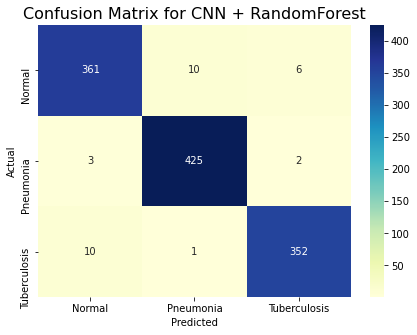

In [ ]:
# Print the Classification report
print(classification_report(y_actual, y_predicted))

# Plot the Confusion Matrix
y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')
confusion_matrix = pd.crosstab(y_actual, y_predicted, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (7,5))
sns.heatmap(confusion_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix for CNN + RandomForest", fontsize=16)
plt.show()